In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\v2_gold_annotation"

In [3]:
MOTION = "HIT"

In [4]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

3


In [5]:
# Keeps values equal to 'X', changes everything else to 'Y'
df['motion_type'] = df['motion_type'].where(df['motion_type'] == f'{MOTION}', f'NOT_{MOTION}')

In [6]:
len(df)

223

In [7]:
df.drop(columns=df.filter(regex=r'^gyro').columns, inplace=True)
df.drop(columns=df.filter(regex=r'^accel').columns, inplace=True)
df.drop(columns=df.filter(regex=r'^mag').columns, inplace=True)

In [8]:
df.head()

,ahrs_x_0,ahrs_y_0,ahrs_z_0,ahrs_w_0,ahrs_x_1,ahrs_y_1,ahrs_z_1,ahrs_w_1,ahrs_x_2,ahrs_y_2,...,ahrs_w_27,ahrs_x_28,ahrs_y_28,ahrs_z_28,ahrs_w_28,ahrs_x_29,ahrs_y_29,ahrs_z_29,ahrs_w_29,motion_type
0,-0.498678,-0.649264,-0.380249,0.430334,-0.520414,-0.628090,-0.403655,0.414409,-0.561269,-0.582446,...,0.176681,-0.040028,-0.967303,0.120068,0.219789,0.015533,-0.952255,0.156887,0.261447,HIT
1,0.629271,0.372604,0.584439,-0.351590,0.628378,0.374344,0.582607,-0.354367,0.625016,0.379964,...,-0.202931,-0.036167,0.933947,-0.236080,-0.265896,-0.079964,0.902073,-0.270397,-0.326735,HIT
2,0.171345,0.579002,0.542231,-0.584280,0.165921,0.582804,0.541757,-0.582503,0.158645,0.587099,...,0.044607,-0.441343,0.858566,-0.260574,0.013489,-0.469362,0.830137,-0.300433,-0.017648,HIT
3,-0.407151,0.757334,-0.201530,-0.469105,-0.401033,0.760700,-0.179581,-0.477765,-0.394703,0.763584,...,0.191834,-0.768425,0.521062,-0.315649,0.195915,-0.775565,0.485217,-0.351109,0.199462,HIT
4,-0.309316,0.620398,0.073042,-0.717004,-0.311374,0.619774,0.072933,-0.716664,-0.315435,0.618766,...,0.421497,-0.870004,0.260731,-0.075689,0.411563,-0.885254,0.320288,-0.133677,0.309632,HIT


<Axes: xlabel='motion_type', ylabel='count'>

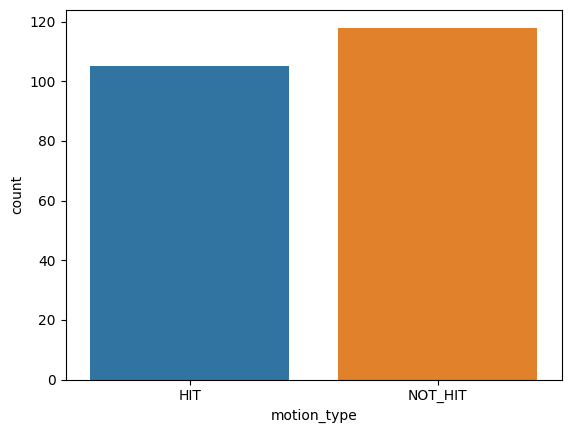

In [9]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [10]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [11]:
n_timesteps = 30
channels = ["ahrs_x", "ahrs_y", "ahrs_z"]
n_channels = len(channels)

X = np.zeros((len(df), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X[:, c, t] = X_df[col_name].values

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

In [14]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [15]:
clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)

In [16]:
clf_minirocket.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf_minirocket.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9777777777777777
0.9615384615384616
1.0
0.9803921568627451
